In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [12]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('D:/OtherBrouhardLab/Brandi')

In [81]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'

EBconc = '[EB] ' r'$(n M)$'

investigator = 'Sofia'

In [14]:
def findmetadata(tag,end,i):
    n = len(tag)
    locstart = str(i).rfind(tag) 
    locend = str(i).find(end, locstart)
    tag0 = str(i)[locstart+n: locend]
    
    return tag0

In [15]:
dateloc = str(path).rfind("202")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-7:] == 'dataset') == True]
folders

[WindowsPath('D:/OtherBrouhardLab/Brandi/2023-04-28_Ch3-tub08uM_DCX-P191R-60nM_EB20nM_finaldataset')]

In [84]:
dates= []
CH= []
tub= []
dcx = []
dcxtype= []
eb = []
for i in folders:
    dateloc = str(i).rfind("202")   
    dates0 = str(i)[dateloc : dateloc+10]
    dates = dates + [dates0]

    CH0 = findmetadata("Ch",'-',i)
    CH = CH + [CH0]  
    
    tub0 = findmetadata("tub",'uM',i)
    tub = tub + [float(tub0)] 
    
    dcx0 = findmetadata("P191R-",'nM',i)
    dcx = dcx + [float(dcx0)]
    
    type0 = findmetadata("DCX-",'-6',i)
    dcxtype = dcxtype + [type0] 
    
    eb0 = findmetadata("EB",'nM',i)
    eb = eb + [float(eb0)]
 

dates,CH,tub,dcx, dcxtype, eb

(['2023-04-28'], ['3'], [8.0], [60.0], ['P191R'], [20.0])

In [85]:
tub_conc =  [float(i) for i in conc_tub]
DCX_conc =  [float(i) for i in conc_DCX]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel =  0.107 #0.107 #0.0633
folders

[WindowsPath('D:/OtherBrouhardLab/Brandi/2023-04-28_Ch3-tub08uM_DCX-P191R-60nM_EB20nM_finaldataset')]

In [86]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,C:\Users\Brouhard Lab\Data\Images\2023-04-28_D...,5.02,0.03,400,1,11.53,130.06


In [87]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame()
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x'][0],'x2': roi_data[key]['x'][1],'x3': roi_data[key]['x'][2],'y1': roi_data[key]['y'][0],'y2': roi_data[key]['y'][1],'y3': roi_data[key]['y'][2]}, ignore_index=True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame()
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [88]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [89]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'kymoslopes.zip')
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date), 'Investigator': np.full((n), investigator),
              'CH': np.full((n), CH[k]),tubulin: np.full((n), tub[k]),DCXconc: np.full((n), dcx[k]),EBconc: np.full((n), eb[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames-2 else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), 
           [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
    
    df['DCX Type'] = dcxtype[k]
        
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslopes.zip')
    #data_even = data.iloc[::2].reset_index()
    #data_odd = data.iloc[1::2].reset_index()
    data_even = data
    data_odd = data
    
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data_even)
    pre_df = {'Date': np.full((n), date),'CH': np.full((n), CH[k]),'Concentration ' r'$(\mu M)$': np.full((n), conc[k])}
    df = pd.DataFrame(pre_df) 
    
    data_even[Length] = abs((data_even['x2']-data_even['x1'])*pixel)
    data_even[Lifetime] = abs((data_even['y2']-data_even['y1'])*spf/60)
    df[GrowthRate] = data_even[Length]/data_even[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data_odd['y2']-data_odd['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df[TimeToNucleate] = ((data_odd[['y1','y2']].min(axis=1))-start)*spf/60
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate]] = np.NaN
    
    df = df[['Date','CH','Concentration ' r'$(\mu M)$',Length,Lifetime,GrowthRate,TimeToNucleate]]
        
    return df

In [90]:
path.parents[0]

WindowsPath('D:/OtherBrouhardLab')

In [91]:
newdirectory = str(path.parents[0])+'//Data_Sheets_Brandi' #'//Data_Sheets_summer'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [92]:
df = pd.DataFrame()
for i in range(0,len(CH)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
df.to_csv(newmydir/(investigator+'_'+date+'.csv'), encoding='utf-8', index=False)
df

,Date,Investigator,CH,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,,Sofia,3,8.0,60.0,20.0,1.847533,1.835089,1.006781,2.401930,1.847533,0.039044,47.318673,False,P191R
1,,Sofia,3,8.0,60.0,20.0,1.443256,1.439845,1.002369,2.119150,1.592558,0.077830,20.462057,False,P191R
2,,Sofia,3,8.0,60.0,20.0,0.995349,1.128527,0.881989,4.921011,1.144651,0.077829,14.707226,False,P191R
3,,Sofia,3,8.0,60.0,20.0,2.792190,3.157990,0.884167,7.621706,2.792190,0.272912,10.231085,False,P191R
4,,Sofia,3,8.0,60.0,20.0,0.882750,1.129500,0.781541,9.558917,0.829250,0.073208,11.327262,False,P191R
5,,Sofia,3,8.0,60.0,20.0,0.882750,1.045833,0.844064,2.353125,0.829250,0.062750,13.215139,False,P191R
6,,Sofia,3,8.0,60.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,P191R
7,,Sofia,3,8.0,60.0,20.0,0.927333,0.920333,1.007606,8.007597,0.927333,0.111555,8.312779,False,P191R
8,,Sofia,3,8.0,60.0,20.0,1.096750,1.024917,1.070087,0.826208,1.337500,0.083667,15.986056,False,P191R
9,,Sofia,3,8.0,60.0,20.0,1.337500,1.401417,0.954391,1.056292,1.337500,0.062750,21.314741,False,P191R


In [94]:
dfmean = df.groupby('CH').mean()
#dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,,
3,8.0,60.0,20.0,1.199269,1.382921,0.896033,6.267156,1.239943,0.089625,16.491689,False


In [68]:
dfstd = df.groupby('CH').std()
#dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,
11,0.0,0.0,2.220003,5.607553,0.065197,2.292193,1.395496,0.921506,0.641015,0.262082
12,0.0,0.0,2.141587,4.409483,0.054800,3.401007,2.164654,0.683917,1.171587,0.308520
13,0.0,0.0,3.114664,5.224431,0.101222,2.719833,1.212097,0.659128,1.351292,0.408032
22,0.0,0.0,2.888860,6.023168,0.068091,0.961065,1.543716,0.755316,0.779552,0.000000


# Preliminary plot Histograms #

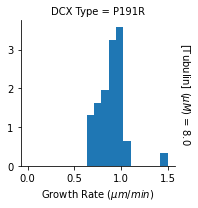

In [95]:
g = sns.FacetGrid(df, row=tubulin, col='DCX Type', margin_titles=True)
bins = np.linspace(0, 1.5, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)

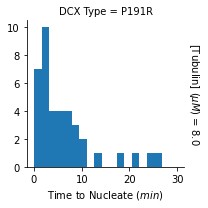

In [96]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 30, 20)
g.map(plt.hist, TimeToNucleate, bins=bins)

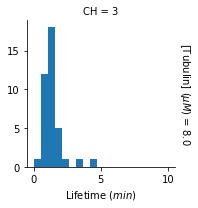

In [98]:
g = sns.FacetGrid(df, row=tubulin, col="CH", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, Lifetime, bins=bins)

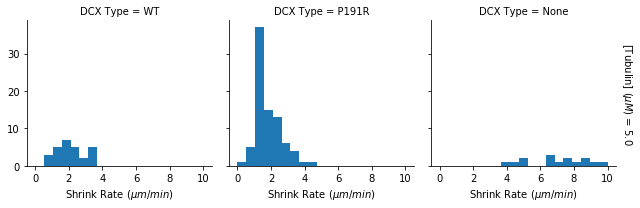

In [53]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)